In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools

#Data prepocessing

In [26]:
trainpath = "D:/Research work/face_mask_detection/dataset/train"
validpath = "D:/Research work/face_mask_detection/dataset/valid"

In [27]:
trainbatches = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.15,
    rotation_range=20,
    zoom_range=2,
    horizontal_flip=True,
    width_shift_range=0.8,
    fill_mode="nearest"
).flow_from_directory(
    directory=trainpath,
    target_size=(224,224),
    batch_size=24,
    shuffle=True,
)

validbatches = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.15,
    rotation_range=20,
    zoom_range=2,
    horizontal_flip=True,
    width_shift_range=0.8,
    fill_mode="nearest"
).flow_from_directory(
    directory=validpath,
    target_size=(224,224),
    batch_size=10,
)

Found 3594 images belonging to 2 classes.
Found 177 images belonging to 2 classes.


In [28]:
basemodel = MobileNetV2(weights="imagenet",
                    include_top=False,
                    input_tensor=Input(shape=(224,224,3)))

In [29]:
for layer in basemodel.layers:
    layer.trainable = False

In [30]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [31]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=basemodel.input, outputs=headModel)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [33]:
import tensorflow
metrics = [
    tensorflow.keras.metrics.Recall(),
    tensorflow.keras.metrics.Precision(),
    tensorflow.keras.metrics.BinaryAccuracy()
]
model.compile(optimizer=Adam(lr = 0.00001),loss="binary_crossentropy",metrics = ['acc'])

#setting for binary classification (with_mask/without_mask)

In [34]:
history = model.fit(
    trainbatches,
    validation_data=validbatches,
    verbose=1,
    epochs=10,
    steps_per_epoch=3594//24,
    validation_steps=177//10
)

Epoch 1/10
149/149 [==============================] - 75s 491ms/step - loss: 0.8234 - acc: 0.5129 - val_loss: 0.6657 - val_acc: 0.6588
Epoch 2/10
149/149 [==============================] - 72s 481ms/step - loss: 0.7325 - acc: 0.5896 - val_loss: 0.6419 - val_acc: 0.6647
Epoch 3/10
149/149 [==============================] - 72s 484ms/step - loss: 0.6866 - acc: 0.6283 - val_loss: 0.6123 - val_acc: 0.7471
Epoch 4/10
149/149 [==============================] - 72s 486ms/step - loss: 0.6564 - acc: 0.6549 - val_loss: 0.5741 - val_acc: 0.7529
Epoch 5/10
149/149 [==============================] - 72s 485ms/step - loss: 0.6270 - acc: 0.6815 - val_loss: 0.5296 - val_acc: 0.8294
Epoch 6/10
149/149 [==============================] - 72s 484ms/step - loss: 0.5954 - acc: 0.7137 - val_loss: 0.5342 - val_acc: 0.8118
Epoch 7/10
149/149 [==============================] - 72s 483ms/step - loss: 0.5823 - acc: 0.7210 - val_loss: 0.5061 - val_acc: 0.8059
Epoch 8/10
149/149 [==============================] - 7

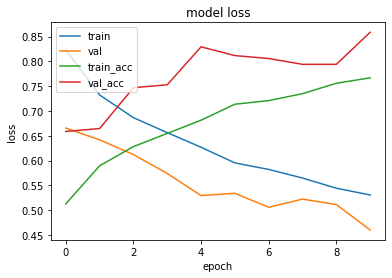

In [35]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_acc','val_acc'], loc='upper left')
plt.show()

In [36]:
model.save("mask_detector.model", save_format="h5")

In [37]:
testbatch = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    directory="D:/Research work/face_mask_detection/dataset/test",
    target_size=(224,224),
    batch_size=2,
    shuffle=False
)

Found 60 images belonging to 2 classes.


In [40]:
model.evaluate(testbatch,verbose=1,steps=30)

30/30 [==============================] - 1s 33ms/step - loss: 0.3266 - acc: 0.9167


[0.32658252120018005, 0.9166666865348816]

In [50]:
# show a nicely formatted classification report
labels= testbatch.classes
testp = model.predict(testbatch,steps=30)
print(classification_report(labels, testp.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [ ]:
model.save("facemaskdetectorr.model", save_format="h5")

In [ ]:
def plot_confusion_matri(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blue):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] Confusion matrix, without normalization
[[28  2]
 [ 3 27]]


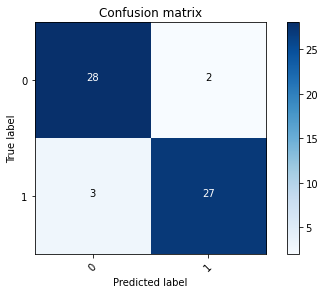

In [43]:
from sklearn.metrics import confusion_matrix
labels= testbatch.classes
testp = model.predict(testbatch,steps=30)
print(testp.argmax(axis=1),end=" ")
cm = confusion_matrix(labels,testp.argmax(axis=1))
cmlabels = ['0','1']
plot_confusion_matri(cm,cmlabels)